In [42]:
import numpy as np
import sympy as smp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sympy import symbols, sin, cos, simplify

from sympy import init_printing

init_printing()

# Double Pendulum Dynamics

In this notebook, we derive the equations of motion for a double pendulum via the Lagrangian formalism and then solve them numerically. Each section is annotated to clarify its purpose.


## 2. Symbol Definitions

We declare all symbols required for the derivation:

- $t$ represents time.
- $g$ is the gravitational acceleration.
- $m_{1}, m_{2}$ are the masses of the first and second bobs.
- $L_{1}, L_{2}$ are the corresponding rod lengths.
- $\theta_{1}(t), \theta_{2}(t)$ denote the angular displacements as functions of time.



In [43]:
t, g = smp.symbols('t g')

m1, m2 = smp.symbols('m1 m2')
L1, L2 = smp.symbols('L1 L2')

theta1_func, theta2_func = smp.symbols(r"\theta_1, \theta_2", cls=smp.Function)

theta1 = theta1_func(t)
theta2 = theta2_func(t)

### 3. First and Second Derivatives

Compute time derivatives of each angle:

- $\dot{\theta}_{i} = \frac{d\theta_{i}}{dt}$
- $\ddot{\theta}_{i} = \frac{d^{2}\theta_{i}}{dt^{2}}$


In [44]:
theta1_d = smp.diff(theta1, t)  # dθ1/dt
theta2_d = smp.diff(theta2, t)  # dθ2/dt
theta1_dd = smp.diff(theta1_d, t)  # d²θ1/dt²
theta2_dd = smp.diff(theta2_d, t)  # d²θ2/dt²

## 4. Cartesian Coordinates of Masses

Express each bob’s position in Cartesian coordinates, using standard planar geometry:

1. First bob (mass $m_{1}$):

   $$
   x_{1} = L_{1}\,\sin\bigl(\theta_{1}\bigr),
   \quad
   y_{1} = -\,L_{1}\,\cos\bigl(\theta_{1}\bigr)
   $$

2. Second bob (mass $m_{2}$), attached to the first:

   $$
   x_{2} = L_{1}\,\sin\bigl(\theta_{1}\bigr) + L_{2}\,\sin\bigl(\theta_{2}\bigr),
   \quad
   y_{2} = -\,L_{1}\,\cos\bigl(\theta_{1}\bigr) - L_{2}\,\cos\bigl(\theta_{2}\bigr)
   $$


In [45]:
x1 = L1 * smp.sin(theta1)
y1 = -L1 * smp.cos(theta1)

x2 = L1 * smp.sin(theta1) + L2 * smp.sin(theta2)
y2 = -L1 * smp.cos(theta1) - L2 * smp.cos(theta2)

## 5. Kinetic and Potential Energies

- **Kinetic Energy** $T$:

  $$
  T = \frac{1}{2}\,m_{1}\,\bigl(\dot{x}_{1}^{2} + \dot{y}_{1}^{2}\bigr)
    + \frac{1}{2}\,m_{2}\,\bigl(\dot{x}_{2}^{2} + \dot{y}_{2}^{2}\bigr)
  $$

- **Potential Energy** $V$:

  $$
  V = m_{1}\,g\,y_{1} + m_{2}\,g\,y_{2}
  $$


In [63]:
x1_dot = smp.diff(x1, t)
y1_dot = smp.diff(y1, t)
x2_dot = smp.diff(x2, t)
y2_dot = smp.diff(y2, t)

T1 = (1 / 2) * m1 * (x1_dot ** 2 + y1_dot ** 2)
T2 = (1 / 2) * m2 * (x2_dot ** 2 + y2_dot ** 2)
T = T1 + T2
T_simpl = simplify(T)

V1 = m1 * g * y1
V2 = m2 * g * y2
V = V1 + V2
V_simpl = simplify(V)

In [64]:
display(T_simpl)


In [65]:
display(V_simpl)

## 6. Lagrangian Formulation

The Lagrangian $\mathcal{L}$ is defined as:

$$
\mathcal{L} = T - V.
$$

We then derive the Euler–Lagrange equations for $\theta_{1}$ and $\theta_{2}$:

$$
\frac{d}{dt}\Bigl(\frac{\partial \mathcal{L}}{\partial \dot{\theta}_{i}}\Bigr)
- \frac{\partial \mathcal{L}}{\partial \theta_{i}} = 0, \quad i = 1,2.
$$


In [49]:
Lagrangian = T - V

EL1 = smp.diff(Lagrangian, theta1) - smp.diff(smp.diff(Lagrangian, theta1_d), t)
EL2 = smp.diff(Lagrangian, theta2) - smp.diff(smp.diff(Lagrangian, theta2_d), t)

EL1_simpl = EL1.simplify()
EL2_simpl = EL2.simplify()

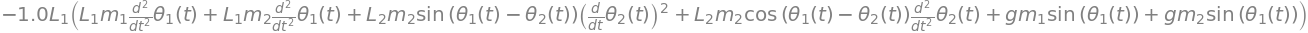

In [50]:
display(EL1_simpl)

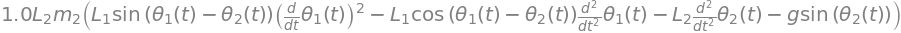

In [51]:
display(EL2_simpl)

## 7. Solve for $\ddot{\theta}_{1}$ and $\ddot{\theta}_{2}$

We solve the two Euler–Lagrange equations simultaneously for $\ddot{\theta}_{1}$ and $\ddot{\theta}_{2}$. This yields symbolic expressions for each angular acceleration in terms of the current state.


In [52]:
solutions = smp.solve([EL1_simpl, EL2_simpl], (theta1_dd, theta2_dd),
                      simplify=False, rational=False)

theta1_dd_expr = solutions[theta1_dd]
theta2_dd_expr = solutions[theta2_dd]
simplified_theta1_dd_expr = simplify(theta1_dd_expr)
simplified_theta2_dd_expr = simplify(theta2_dd_expr)

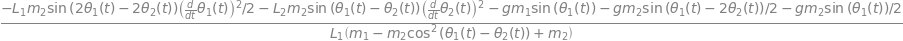

In [53]:
display(simplified_theta1_dd_expr)

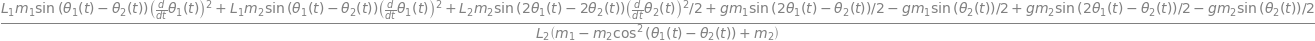

In [54]:
display(simplified_theta2_dd_expr)

## 8. Numerical Lambdification

Convert the symbolic expressions into fast numerical functions using `lambdify`.

These functions accept arguments:

$$
\bigl(t,\,g,\,m_{1},\,m_{2},\,L_{1},\,L_{2},\,\theta_{1},\,\theta_{2},\,\dot{\theta}_{1},\,\dot{\theta}_{2}\bigr)
$$

and return the corresponding $\ddot{\theta}$.


In [55]:
dz1dt_func = smp.lambdify(
    (t, g, m1, m2, L1, L2, theta1, theta2, theta1_d, theta2_d),
    theta1_dd_expr,
    'numpy'
)

dz2dt_func = smp.lambdify(
    (t, g, m1, m2, L1, L2, theta1, theta2, theta1_d, theta2_d),
    theta2_dd_expr,
    'numpy'
)

dtheta1dt_func = smp.lambdify(theta1_d, theta1_d, 'numpy')
dtheta2dt_func = smp.lambdify(theta2_d, theta2_d, 'numpy')

## 9. State–Space System: $\frac{dS}{dt}$

We define the vector:

$$
S = \bigl[\theta_{1},\,z_{1},\,\theta_{2},\,z_{2}\bigr], \quad \text{where } z_{i} = \dot{\theta}_{i}.
$$

The ODE system is:

$$
\begin{cases}
\dot{\theta}_{1} = z_{1},\\
\dot{z}_{1} = f_{1}\bigl(t,\,g,\,m_{1},\,m_{2},\,L_{1},\,L_{2},\,\theta_{1},\,\theta_{2},\,z_{1},\,z_{2}\bigr),\\
\dot{\theta}_{2} = z_{2},\\
\dot{z}_{2} = f_{2}\bigl(t,\,g,\,m_{1},\,m_{2},\,L_{1},\,L_{2},\,\theta_{1},\,\theta_{2},\,z_{1},\,z_{2}\bigr).
\end{cases}
$$


In [56]:
def dSdt(S, t, g, m1, m2, L1, L2):

    theta1_val, z1_val, theta2_val, z2_val = S

    return [
        dtheta1dt_func(z1_val),
        dz1dt_func(t, g, m1, m2, L1, L2, theta1_val, theta2_val, z1_val, z2_val),
        dtheta2dt_func(z2_val),
        dz2dt_func(t, g, m1, m2, L1, L2, theta1_val, theta2_val, z1_val, z2_val),
    ]

## 10. Initial Conditions and Parameters

Set numerical values for all parameters and specify an initial state:

- $\theta_{1}(0) = 1\ \mathrm{rad}, \quad \dot{\theta}_{1}(0) = -3\ \mathrm{rad/s}$
- $\theta_{2}(0) = -1\ \mathrm{rad}, \quad \dot{\theta}_{2}(0) = 5\ \mathrm{rad/s}$

- $m_{1} = 2,\ m_{2} = 1,\ L_{1} = 2,\ L_{2} = 1,\ g = 9.81\ \mathrm{m/s^{2}}$.

These values will be used when calling the numerical integrator.


In [57]:
t_vals = np.linspace(0, 40, 1001)

g_val = 9.81
m1_val = 2.0
m2_val = 1.0
L1_val = 2.0
L2_val = 1.0

initial_state = [1.0, -3.0, -1.0, 5.0]

solution = odeint(
    dSdt,
    y0=initial_state,
    t=t_vals,
    args=(g_val, m1_val, m2_val, L1_val, L2_val)
)

## 11. Extract Angles and Plot

Finally, we extract $\theta_{1}(t)$ and $\theta_{2}(t)$ from the solution array and plot one of them as an example. You can similarly plot $\theta_{1}$ or any other quantity of interest.


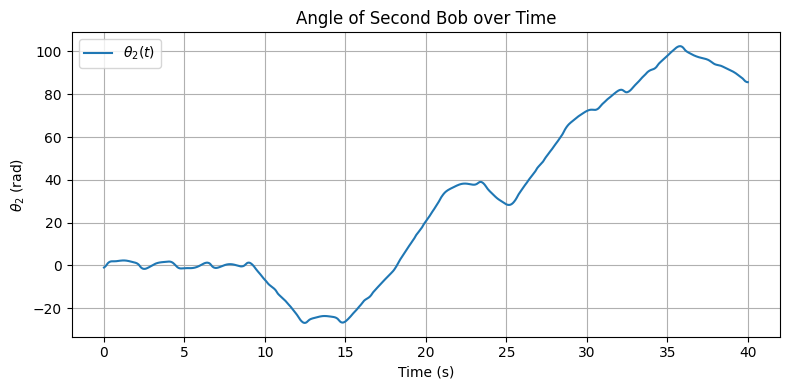

In [58]:
theta1_time_series = solution[:, 0]
theta2_time_series = solution[:, 2]

plt.figure(figsize=(8, 4))
plt.plot(t_vals, theta2_time_series, label=r'$\theta_2(t)$')
plt.xlabel('Time (s)')
plt.ylabel(r'$\theta_2$ (rad)')
plt.title('Angle of Second Bob over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


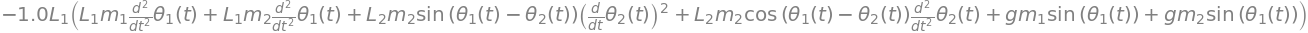

In [59]:
display(EL1_simpl)

In [66]:
from sympy import latex, simplify

def write_expr_to_file(f, label, expr):
    """
    Write a single SymPy expression to an open file in LaTeX display form.
    """
    f.write(f"% {label}\n")
    f.write("$$\n")
    f.write(latex(expr))
    f.write("\n$$\n\n")


# ——————————————————————————————————————————
# After your computations, you now have:
#   T_simpl, V_simpl,
#   EL1_simpl, EL2_simpl,
#   simplified_theta1_dd_expr, simplified_theta2_dd_expr
# ——————————————————————————————————————————

output_path = "double_pendulum_equations.tex"
with open(output_path, "w", encoding="utf-8") as f:
    # Section 5: simplified energies
    write_expr_to_file(f, "Simplified kinetic energy T",   T_simpl)
    write_expr_to_file(f, "Simplified potential energy V", V_simpl)

    # Section 6: Euler–Lagrange equations
    write_expr_to_file(f, "Euler–Lagrange for θ₁",         EL1_simpl)
    write_expr_to_file(f, "Euler–Lagrange for θ₂",         EL2_simpl)

    # Section 7: angular accelerations
    write_expr_to_file(f, "Simplified θ̈₁",                 simplified_theta1_dd_expr)
    write_expr_to_file(f, "Simplified θ̈₂",                 simplified_theta2_dd_expr)

print(f"Wrote all display outputs to {output_path}")


Wrote all display outputs to double_pendulum_equations.tex
